In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Helper Functions
# -------------------------------

def encode_teams(df, team_columns):
    encoders = {}
    for col in team_columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoders[col] = encoder
    return df, encoders

def decode_label(encoder, value):
    return encoder.inverse_transform([value])[0] if value in range(len(encoder.classes_)) else "Unknown"

def calculate_team_aggregates(players_df):
    team_stats = players_df.groupby(['MatchID', 'Team']).agg({
        'Runs': 'mean',
        'StrikeRate': 'mean',
        'Wickets': 'sum',
        'Fours': 'sum',
        'Sixes': 'sum'
    }).reset_index()
    return team_stats

def merge_team_stats(match_df, team_stats):
    merged_df = match_df.copy()
    merged_df = pd.merge(merged_df, team_stats, left_on=['MatchID', 'TeamA'], right_on=['MatchID', 'Team'])
    merged_df.rename(columns={
        'Runs': 'TeamA_AvgRuns',
        'StrikeRate': 'TeamA_StrikeRate',
        'Wickets': 'TeamA_Wickets',
        'Fours': 'TeamA_Fours',
        'Sixes': 'TeamA_Sixes'
    }, inplace=True)
    merged_df.drop(columns=['Team'], inplace=True)

    merged_df = pd.merge(merged_df, team_stats, left_on=['MatchID', 'TeamB'], right_on=['MatchID', 'Team'])
    merged_df.rename(columns={
        'Runs': 'TeamB_AvgRuns',
        'StrikeRate': 'TeamB_StrikeRate',
        'Wickets': 'TeamB_Wickets',
        'Fours': 'TeamB_Fours',
        'Sixes': 'TeamB_Sixes'
    }, inplace=True)
    merged_df.drop(columns=['Team'], inplace=True)

    return merged_df

def calculate_win_ratio(matches_df):
    win_counts = matches_df['Winner'].value_counts().to_dict()
    match_counts = {}
    for team in pd.concat([matches_df['TeamA'], matches_df['TeamB']]):
        match_counts[team] = match_counts.get(team, 0) + 1

    win_ratios = {team: win_counts.get(team, 0) / match_counts[team] for team in match_counts}
    return win_ratios

def add_win_ratios(df, win_ratios):
    df['TeamA_WinRatio'] = df['TeamA'].map(win_ratios)
    df['TeamB_WinRatio'] = df['TeamB'].map(win_ratios)
    return df

def build_features(df):
    features = [
        'TeamA', 'TeamB',
        'TeamA_AvgRuns', 'TeamA_StrikeRate', 'TeamA_Wickets', 'TeamA_Fours', 'TeamA_Sixes', 'TeamA_WinRatio',
        'TeamB_AvgRuns', 'TeamB_StrikeRate', 'TeamB_Wickets', 'TeamB_Fours', 'TeamB_Sixes', 'TeamB_WinRatio'
    ]
    return df[features], df['WinnerBinary']

def predict_single_match(model, encoders, team_a, team_b, features):
    team_a_classes = list(encoders['TeamA'].classes_)
    team_b_classes = list(encoders['TeamB'].classes_)

    if team_a not in team_a_classes:
        print(f"\n'{team_a}' is not in the training data. Selecting fallback: {team_a_classes[0]}")
        team_a = team_a_classes[0]

    if team_b not in team_b_classes:
        print(f"\n'{team_b}' is not in the training data. Selecting fallback: {team_b_classes[1]}")
        team_b = team_b_classes[1]

    team_a_enc = encoders['TeamA'].transform([team_a])[0]
    team_b_enc = encoders['TeamB'].transform([team_b])[0]

    feature_order = [
        'TeamA', 'TeamB',
        'TeamA_AvgRuns', 'TeamA_StrikeRate', 'TeamA_Wickets', 'TeamA_Fours', 'TeamA_Sixes', 'TeamA_WinRatio',
        'TeamB_AvgRuns', 'TeamB_StrikeRate', 'TeamB_Wickets', 'TeamB_Fours', 'TeamB_Sixes', 'TeamB_WinRatio'
    ]

    sample_data = {
        'TeamA': team_a_enc,
        'TeamB': team_b_enc,
        'TeamA_AvgRuns': features['TeamA_AvgRuns'],
        'TeamA_StrikeRate': features['TeamA_StrikeRate'],
        'TeamA_Wickets': features['TeamA_Wickets'],
        'TeamA_Fours': features['TeamA_Fours'],
        'TeamA_Sixes': features['TeamA_Sixes'],
        'TeamA_WinRatio': features['TeamA_WinRatio'],
        'TeamB_AvgRuns': features['TeamB_AvgRuns'],
        'TeamB_StrikeRate': features['TeamB_StrikeRate'],
        'TeamB_Wickets': features['TeamB_Wickets'],
        'TeamB_Fours': features['TeamB_Fours'],
        'TeamB_Sixes': features['TeamB_Sixes'],
        'TeamB_WinRatio': features['TeamB_WinRatio']
    }

    sample = pd.DataFrame([[sample_data[col] for col in feature_order]], columns=feature_order)
    return model.predict(sample)[0]

def create_custom_team(player_pool, team_name, n_players=11):
    print(f"\nBuilding custom team for {team_name}")
    total_players = min(len(player_pool), n_players)
    if total_players < n_players:
        print(f"Warning: Only {total_players} players available. Selecting with replacement.")
    available = player_pool.sample(n=n_players, replace=True).reset_index(drop=True)
    print(available[['Player', 'Runs', 'StrikeRate', 'Wickets']])
    team = available.head(n_players)
    print(f"\nSelected team for {team_name}:")
    print(team[['Player', 'Runs', 'StrikeRate', 'Wickets']])
    team_agg = {
        'AvgRuns': team['Runs'].mean(),
        'StrikeRate': team['StrikeRate'].mean(),
        'Wickets': team['Wickets'].sum(),
        'Fours': team['Fours'].sum(),
        'Sixes': team['Sixes'].sum()
    }
    return team_agg

def load_real_data():
    match_df = pd.read_csv('psl_matches.csv')
    player_df = pd.read_csv('psl_players.csv')
    player_pool_df = player_df.drop(columns=['MatchID', 'Team']).drop_duplicates('Player')
    return match_df, player_df, player_pool_df

def main():
    print("\nLoading and preparing real PSL data from CSV...")
    match_df, player_df, player_pool = load_real_data()

    team_stats = calculate_team_aggregates(player_df)
    merged_df = merge_team_stats(match_df, team_stats)

    merged_df, team_encoders = encode_teams(merged_df, ['TeamA', 'TeamB', 'Winner'])

    win_ratios = calculate_win_ratio(match_df)
    merged_df = add_win_ratios(merged_df, win_ratios)

    merged_df['WinnerBinary'] = (merged_df['Winner'] == merged_df['TeamA']).astype(int)

    X, y = build_features(merged_df)

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    print("\nTraining model...")
    model = GradientBoostingClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("\nModel Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    team_a_features = create_custom_team(player_pool, 'CustomTeamA')
    team_b_features = create_custom_team(player_pool, 'CustomTeamB')

    sample = {
        'TeamA_AvgRuns': team_a_features['AvgRuns'],
        'TeamA_StrikeRate': team_a_features['StrikeRate'],
        'TeamA_Wickets': team_a_features['Wickets'],
        'TeamA_Fours': team_a_features['Fours'],
        'TeamA_Sixes': team_a_features['Sixes'],
        'TeamA_WinRatio': 0.60,
        'TeamB_AvgRuns': team_b_features['AvgRuns'],
        'TeamB_StrikeRate': team_b_features['StrikeRate'],
        'TeamB_Wickets': team_b_features['Wickets'],
        'TeamB_Fours': team_b_features['Fours'],
        'TeamB_Sixes': team_b_features['Sixes'],
        'TeamB_WinRatio': 0.50
    }

    result = predict_single_match(model, team_encoders, 'Islamabad United', 'Multan Sultans', sample)
    if result is not None:
        print("\nPredicted Winner: Custom Team A" if result == 1 else "\nPredicted Winner: Custom Team B")

if __name__ == "__main__":
    main()


Loading and preparing real PSL data from CSV...


ValueError: Shape of passed values is (4, 12), indices imply (4, 14)

In [ ]:
file_path = 'psl_matches.csv'
df = pd.read_csv(file_path)
display(df)

,MatchID,TeamA,TeamB,Winner
0,1,Lahore Qalandars,Karachi Kings,Lahore Qalandars
1,2,Islamabad United,Peshawar Zalmi,Peshawar Zalmi
2,3,Multan Sultans,Quetta Gladiators,Multan Sultans
3,4,Lahore Qalandars,Multan Sultans,Multan Sultans


In [ ]:
file_path2 = 'psl_players.csv'
df2 = pd.read_csv(file_path2)
display(df2)

,MatchID,Team,Player,Runs,StrikeRate,Wickets,Fours,Sixes
0,1,Lahore Qalandars,Player1,45,130.5,2,4,2
1,1,Lahore Qalandars,Player2,30,140.0,0,3,1
2,1,Karachi Kings,Player3,50,125.0,1,5,2
3,1,Karachi Kings,Player4,28,110.5,1,2,0
4,2,Islamabad United,Player5,60,135.0,1,4,3
5,2,Islamabad United,Player6,20,100.0,0,2,0
6,2,Peshawar Zalmi,Player7,48,145.0,2,5,2
7,2,Peshawar Zalmi,Player8,35,115.0,0,4,1
8,3,Multan Sultans,Player9,70,150.0,1,6,4
9,3,Quetta Gladiators,Player10,30,120.0,1,3,1


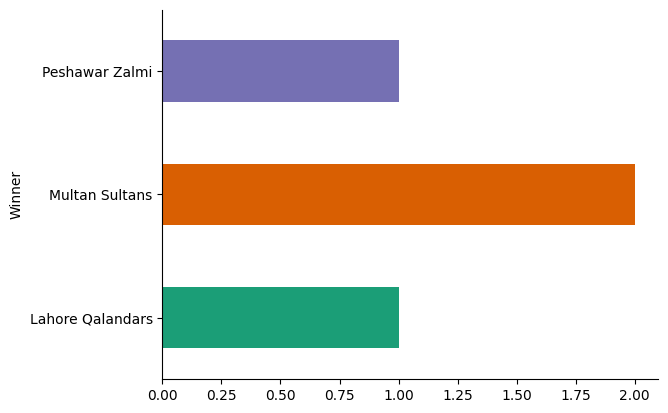

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Winner').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)